# Adam: Exercise

For this exercise we will be build Adam up from scratch starting with regular gradient descent. We will also be utilizing mini batches to introduce stochasticity to the optimization. 

We will be working with the mnist_784 data set and a simple shallow neural network. 

If you do not have scikit-learn then you can get it here: https://scikit-learn.org/stable/install.html

This code is heavily inspired by Doug’s code from CSCI 447/547 lecture 05_multilayer_perceptron.

First we need to get the data, define the network and define some functions to perform on the data. You don’t need to do anything with this first block of code. 

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X[::5]
y = y.astype(int)[::5]
X, X_test, y, y_test = train_test_split(X, y)

# Here we specify the size of our neural network.
# We are mapping from 784 to 10 with 256 hiden layer nodes.

m = len(X)
n_0 = 784
n_1 = 256
N = 10


# Function to convert categorical labels into one-hot matrix.
def convert_to_one_hot(y, n_classes):
    T = np.zeros((y.shape[0], n_classes))
    for t, yy in zip(T, y):
        t[yy] = 1
    return T


# Convert the data to one hot notation
one_hot_y_actual = convert_to_one_hot(y, N)
one_hot_y_test = convert_to_one_hot(y_test, N)


# Sigmoid function (activation)
def sigmoid(a):
    return 1. / (1 + np.exp(-a))


# Softmax function (final layer for classification)
def softmax(A):
    numerator = np.exp(A)
    denominator = numerator.sum(axis=1)
    return numerator / denominator[:, np.newaxis]


# Categorical cross-entropy
def L(T, S, W1, W2, alpha_1=1e-2, alpha_2=1e-5):
    return -1. / len(T) * np.sum(T * np.log(S)) + np.sum(0.5 * alpha_1 * W1 ** 2) + np.sum(0.5 * alpha_2 * W2 ** 2)


# Run the neural network forward, given some weights and biases
def feedforward(X, W1, W2, b1, b2):
    # Feedforward
    A1 = X @ W1 + b1
    Z1 = sigmoid(A1)
    A2 = Z1 @ W2 + b2
    y_pred = softmax(A2)
    return y_pred, Z1


# Compute the neural network gradients using backpropagation
def backpropogate(y_pred, Z1, X, y_obs, alpha_1=1e-2, alpha_2=1e-5):
    # Backpropogate
    delta_2 = (1. / len(y_pred)) * (y_pred - y_obs)
    grad_W2 = Z1.T @ delta_2 + alpha_2 * W2
    grad_b2 = delta_2.sum(axis=0)

    delta_1 = delta_2 @ W2.T * Z1 * (1 - Z1)
    grad_W1 = X.T @ delta_1 + alpha_1 * W1
    grad_b1 = delta_1.sum(axis=0)
    return grad_W1, grad_W2, grad_b1, grad_b2


def mini_batch(x_sample, y_sample, start_batch_size):
    """
    Takes a copy of x_sample and y_sample and returns mini batch matrices of both and number of batches
    """

    # Batches must divide evenly into total number of samples for numpy arrays to be happy.
    # Gets number of bathes by finding next smallest number that evenly divides
    num_batches = start_batch_size
    while len(x_sample) % num_batches != 0:
        num_batches -= 1

    # randomly shuffle indices
    np.random.seed(42)
    random_indices = np.random.choice(range(len(x_sample)), len(x_sample), replace=False)

    # instantiate lists to hold batches
    x_list = [[] for i in range(num_batches)]
    y_list = [[] for i in range(num_batches)]

    # populate batches matrix with random mini batch indices
    for i in range(len(x_sample)):

        x_list[i // 105].append(x_sample[random_indices[i]])
        y_list[i // 105].append(y_sample[random_indices[i]])
    
    # Convert to numpy arrays
    x_batch = np.array(x_list)
    y_batch = np.array(y_list)

    return x_batch, y_batch, num_batches, num_batches


# Vanilla Gradient Descent

For our first exercise we will implement plain old gradient descent. The mathematical formula is:

$$ \theta_t = \theta_{t-1} - \alpha \nabla f(\theta_{t-1}) \tag{1}$$
---

We have already specified initial values for the $\alpha$ and the batch size but feel free to play around with it. The location to insert your gradient descent implementation is outlined with a multi-line comment.  

In [17]:
"""
Vanilla Gradient Descent
"""

# Hyper Parameters
eta = 1e-3
initial_batch_size = 104
epochs = 250

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
vanilla_loss = []

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)
        
        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        W1 -= eta * grad_W1
        W2 -= eta * grad_W2
        b1 -= eta * grad_b1
        b2 -= eta * grad_b2

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    vanilla_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.167020 Accuracy 0.645143
Epoch 10 Loss 0.774346 Accuracy 0.888286
Epoch 20 Loss 0.461379 Accuracy 0.908857
Epoch 30 Loss 0.339183 Accuracy 0.914857
Epoch 40 Loss 0.273341 Accuracy 0.918000
Epoch 50 Loss 0.231435 Accuracy 0.918571
Epoch 60 Loss 0.202412 Accuracy 0.919143
Epoch 70 Loss 0.180699 Accuracy 0.918857
Epoch 80 Loss 0.163916 Accuracy 0.920857
Epoch 90 Loss 0.150626 Accuracy 0.923714
Epoch 100 Loss 0.139820 Accuracy 0.924571
Epoch 110 Loss 0.130784 Accuracy 0.927143
Epoch 120 Loss 0.123074 Accuracy 0.927429
Epoch 130 Loss 0.116477 Accuracy 0.927714
Epoch 140 Loss 0.110637 Accuracy 0.928571
Epoch 150 Loss 0.105539 Accuracy 0.929143
Epoch 160 Loss 0.101012 Accuracy 0.929429
Epoch 170 Loss 0.097052 Accuracy 0.929143
Epoch 180 Loss 0.093477 Accuracy 0.929143
Epoch 190 Loss 0.090244 Accuracy 0.929429
Epoch 200 Loss 0.087343 Accuracy 0.930000
Epoch 210 Loss 0.084694 Accuracy 0.930000
Epoch 220 Loss 0.082270 Accuracy 0.930000
Epoch 230 Loss 0.080050 Accuracy 0.930286
Epo

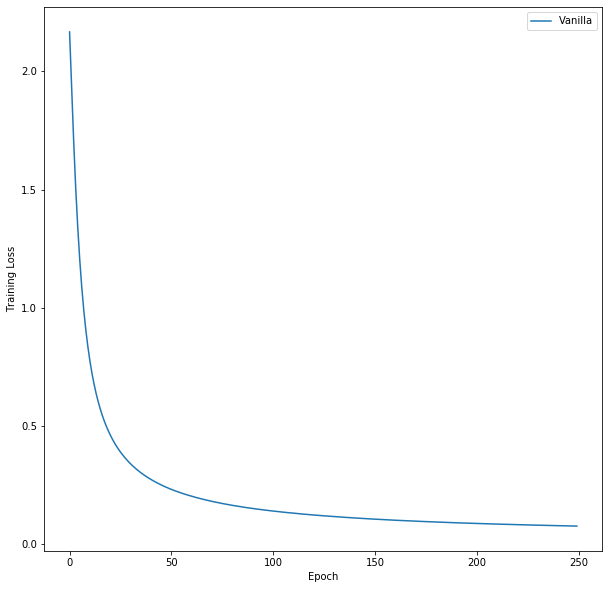

In [18]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Momentum Gradient Descent

Next we will add momentum. The the new update rule is:

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$ \beta_1 \in [0,1)$$
---

$$\theta_{t}=\theta_{t-1} - \alpha m_{t} \tag{2}$$
---

In [19]:
"""
Momentum Gradient Descent
"""

# Hyper Parameters
eta = 1e-3
initial_batch_size = 104
epochs = 250
"""
You need to add another hyper parameter here. Hint! look at the equation above
"""
beta1 = 0.9

# data for analysis
momentum_loss = []

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

"""
You probably need to initialize your momentum here... 
"""
m1 = 0
m2 = 0
mb1 = 0
mb2 = 0

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        m1 = (beta1 * m1) + ((1 - beta1) * grad_W1)
        m2 = (beta1 * m2) + ((1 - beta1) * grad_W2)
        W1 -= eta * m1
        W2 -= eta * m2
        mb1 = (beta1 * mb1) + ((1 - beta1) * grad_b1)
        mb2 = (beta1 * mb2) + ((1 - beta1) * grad_b2)
        b1 -= eta * mb1
        b2 -= eta * mb2

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    momentum_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.197993 Accuracy 0.584571
Epoch 10 Loss 0.783490 Accuracy 0.888857
Epoch 20 Loss 0.460564 Accuracy 0.909714
Epoch 30 Loss 0.337191 Accuracy 0.915429
Epoch 40 Loss 0.271864 Accuracy 0.916857
Epoch 50 Loss 0.230455 Accuracy 0.918286
Epoch 60 Loss 0.201627 Accuracy 0.919143
Epoch 70 Loss 0.180309 Accuracy 0.921429
Epoch 80 Loss 0.163928 Accuracy 0.921714
Epoch 90 Loss 0.150758 Accuracy 0.924000
Epoch 100 Loss 0.139906 Accuracy 0.924000
Epoch 110 Loss 0.130782 Accuracy 0.924571
Epoch 120 Loss 0.123019 Accuracy 0.925714
Epoch 130 Loss 0.116270 Accuracy 0.925714
Epoch 140 Loss 0.110467 Accuracy 0.926286
Epoch 150 Loss 0.105353 Accuracy 0.926286
Epoch 160 Loss 0.100873 Accuracy 0.926571
Epoch 170 Loss 0.096883 Accuracy 0.926571
Epoch 180 Loss 0.093224 Accuracy 0.927143
Epoch 190 Loss 0.089925 Accuracy 0.927714
Epoch 200 Loss 0.086983 Accuracy 0.927429
Epoch 210 Loss 0.084273 Accuracy 0.927143
Epoch 220 Loss 0.081713 Accuracy 0.927714
Epoch 230 Loss 0.079338 Accuracy 0.927714
Epo

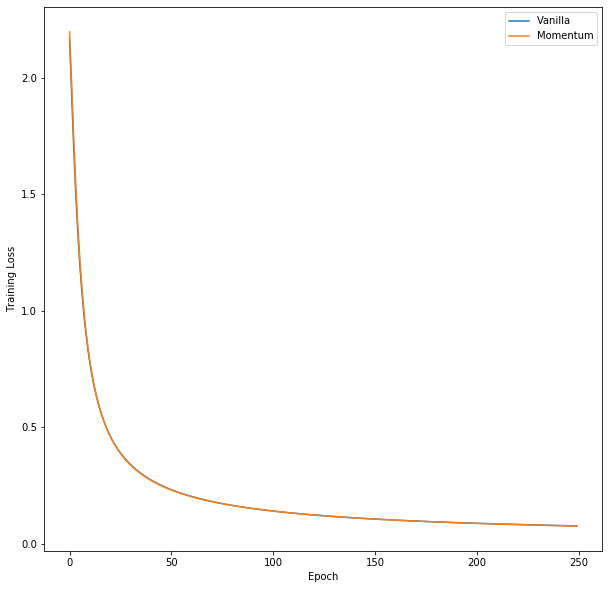

In [20]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# RMSProp Gradient Descent 

Next we will do RMSProp. The update rule is as follows:

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$ \beta_2 \in [0,1)$$
---

$$\theta_{t} = \theta_{t-1} - \alpha \frac { \nabla f(\theta_{t-1})}{\sqrt{v_{t} + \epsilon}} \tag{3}$$ 
---


In [21]:
"""
RMSProp Gradient Descent
"""

# Hyper Parameters
eta = 1e-3
initial_batch_size = 104
epochs = 250
"""
You need to add two hyper parameters here. Hint! look at the equation above
"""
beta1 = 0.9
beta2 = 0.99


# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
RMS_loss = []

"""
You probably need to initialize your variance here...
"""
m1 = 0
m2 = 0
v1 = 0
v2 = 0
mb1 = 0
mb2 = 0
vb1 = 0
vb2 = 0
eps = 1e-10


# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        m1 = (beta1 * m1) + ((1 - beta1) * grad_W1)
        m2 = (beta1 * m2) + ((1 - beta1) * grad_W2)
        v1 = (beta2 * v1) + ((1 - beta2) * grad_W1**2)
        v2 = (beta2 * v2) + ((1 - beta2) * grad_W2**2)
        W1 -= eta * grad_W1 / np.sqrt(v1 + eps)
        W2 -= eta * grad_W2 / np.sqrt(v2 + eps)
        
        mb1 = (beta1 * m1) + ((1 - beta1) * grad_W1)
        mb2 = (beta1 * m2) + ((1 - beta1) * grad_W2)
        vb1 = (beta2 * vb1) + ((1 - beta2) * grad_b1**2)
        vb2 = (beta2 * vb2) + ((1 - beta2) * grad_b2**2)
        b1 -= eta * grad_b1 / np.sqrt(vb1 + eps)
        b2 -= eta * grad_b2 / np.sqrt(vb2 + eps)
       

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    RMS_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


/Users/Fred/anaconda3/envs/p3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in exp


Epoch 0 Loss 0.656783 Accuracy 0.867429
Epoch 10 Loss 0.405606 Accuracy 0.914000
Epoch 20 Loss 0.385977 Accuracy 0.922000
Epoch 30 Loss 0.364535 Accuracy 0.922571
Epoch 40 Loss 0.371850 Accuracy 0.912857
Epoch 50 Loss 0.356753 Accuracy 0.922286
Epoch 60 Loss 0.342470 Accuracy 0.917429
Epoch 70 Loss 0.337900 Accuracy 0.928000
Epoch 80 Loss 0.347677 Accuracy 0.917714
Epoch 90 Loss 0.333562 Accuracy 0.928000
Epoch 100 Loss 0.347492 Accuracy 0.920286
Epoch 110 Loss 0.360289 Accuracy 0.923714
Epoch 120 Loss 0.396698 Accuracy 0.909429
Epoch 130 Loss 0.358611 Accuracy 0.913714
Epoch 140 Loss 0.345324 Accuracy 0.916286
Epoch 150 Loss 0.378774 Accuracy 0.910857
Epoch 160 Loss 0.350318 Accuracy 0.914571
Epoch 170 Loss 0.371948 Accuracy 0.914286
Epoch 180 Loss 0.344162 Accuracy 0.914857
Epoch 190 Loss 0.357712 Accuracy 0.917143
Epoch 200 Loss 0.355400 Accuracy 0.913429
Epoch 210 Loss 0.340446 Accuracy 0.918857
Epoch 220 Loss 0.362340 Accuracy 0.913429
Epoch 230 Loss 0.378183 Accuracy 0.906857
Epo

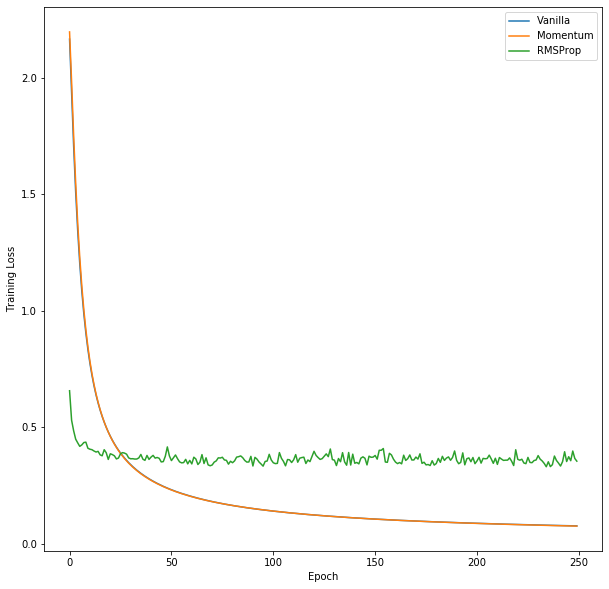

In [22]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Adam Gradient Descent 

Now we put them both together and we get Adam!

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$\hat m_{t} = \frac {m_{t}}{1 - \beta_1^{t}}$$
---

$$\hat v_t = \frac {v_{t}}{1 - \beta_2^{t}}$$
---

$$\theta_t = \theta_{t-1} - \alpha \frac {\hat m_t}{\sqrt{\hat v_t + \epsilon}} \tag{4}$$
---

Play around with the hyperparameters to see if you can get distinctly different behavior from the optimization.

In [25]:
"""
Adam Gradient Descent
"""

# Hyper Parameters
eta = 1e-3
initial_batch_size = 104
epochs = 250
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""
beta1 = 0.8
beta2 = 0.9
eps = 1e-10

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
Adam_loss = []

"""
You probably need to initialize your variance and momentum here...
"""
m1 = 0
m2 = 0
v1 = 0
v2 = 0
mb1 = 0
mb2 = 0
vb1 = 0
vb2 = 0

t = 1

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        m1 = (beta1 * m1) + ((1 - beta1) * grad_W1)
        m2 = (beta1 * m2) + ((1 - beta1) * grad_W2)
        v1 = (beta2 * v1) + ((1 - beta2) * grad_W1**2)
        v2 = (beta2 * v2) + ((1 - beta2) * grad_W2**2)
        mhat1 = m1 / (1 - beta1**t)
        mhat2 = m2 / (1 - beta1**t)
        vhat1 = v1 / (1 - beta2**t)
        vhat2 = v2 / (1 - beta2**t)
        W1 -= eta * grad_W1 / np.sqrt(vhat1 + eps)
        W2 -= eta * grad_W2 / np.sqrt(vhat2 + eps)
        
        mb1 = (beta1 * m1) + ((1 - beta1) * grad_W1)
        mb2 = (beta1 * m2) + ((1 - beta1) * grad_W2)
        vb1 = (beta2 * vb1) + ((1 - beta2) * grad_b1**2)
        vb2 = (beta2 * vb2) + ((1 - beta2) * grad_b2**2)
        mbhat1 = mb1 / (1 - beta1**t)
        mbhat2 = mb2 / (1 - beta1**t)
        vbhat1 = vb1 / (1 - beta2**t)
        vbhat2 = vb2 / (1 - beta2**t)
        b1 -= eta * grad_b1 / np.sqrt(vbhat1 + eps)
        b2 -= eta * grad_b2 / np.sqrt(vbhat2 + eps)
        
        t += 1

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    Adam_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 0.516969 Accuracy 0.883143
Epoch 10 Loss 0.285202 Accuracy 0.922571
Epoch 20 Loss 0.264817 Accuracy 0.925714
Epoch 30 Loss 0.249418 Accuracy 0.922571


/Users/Fred/anaconda3/envs/p3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in exp


Epoch 40 Loss 0.257967 Accuracy 0.921143
Epoch 50 Loss 0.238230 Accuracy 0.926000
Epoch 60 Loss 0.242601 Accuracy 0.928286
Epoch 70 Loss 0.251189 Accuracy 0.923714
Epoch 80 Loss 0.239393 Accuracy 0.922286
Epoch 90 Loss 0.254599 Accuracy 0.920286
Epoch 100 Loss 0.232562 Accuracy 0.926286
Epoch 110 Loss 0.254729 Accuracy 0.916571
Epoch 120 Loss 0.241583 Accuracy 0.923714
Epoch 130 Loss 0.237468 Accuracy 0.924857
Epoch 140 Loss 0.251579 Accuracy 0.918857
Epoch 150 Loss 0.263447 Accuracy 0.909714
Epoch 160 Loss 0.237938 Accuracy 0.928286
Epoch 170 Loss 0.232807 Accuracy 0.924571
Epoch 180 Loss 0.277427 Accuracy 0.901143
Epoch 190 Loss 0.266485 Accuracy 0.910000
Epoch 200 Loss 0.234367 Accuracy 0.922000
Epoch 210 Loss 0.283126 Accuracy 0.914286
Epoch 220 Loss 0.251316 Accuracy 0.916571
Epoch 230 Loss 0.230012 Accuracy 0.924857
Epoch 240 Loss 0.269961 Accuracy 0.911714


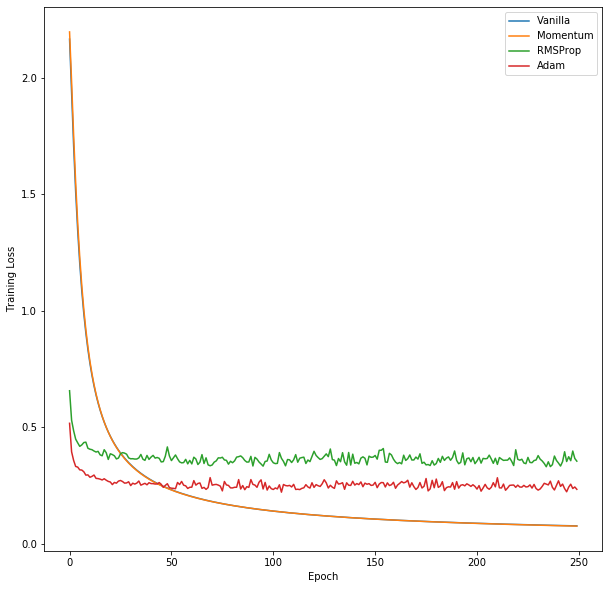

In [26]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.plot(Adam_loss, label='Adam')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()